In [1]:
import statsmodels.api as sm

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray.plot as xplt
import cftime

In [199]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

In [273]:
cpmdata = xr.open_mfdataset("../../../data/2.2km/rcp85/01/pr/*.nc").rename({"pr": "target_pr"})
gcmdata = xr.open_mfdataset("../../../data/60km/rcp85/01/*/day/*.nc")
regridded_gcmdata = xr.open_mfdataset('../../../derived_data/60km/rcp85/01/*/day/*.nc')

In [274]:
cpmdata = cpmdata.loc[dict(ensemble_member=1, time=slice("1980-12-01","1982-11-30"))].isel(grid_latitude=100, grid_longitude=100)
cpmdata = cpmdata.reset_coords()[['target_pr']]
cpmdata

<xarray.Dataset>
Dimensions:    (time: 720)
Coordinates:
  * time       (time) object 1980-12-01 12:00:00 ... 1982-11-30 12:00:00
Data variables:
    target_pr  (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-30T06:13:12
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

In [275]:
regridded_gcmdata = regridded_gcmdata.loc[dict(ensemble_member=1, time=slice("1980-12-01","1982-11-30"))].isel(grid_latitude=100, grid_longitude=100)
regridded_gcmdata = regridded_gcmdata.reset_coords()[['pr', 'psl']]
regridded_gcmdata

<xarray.Dataset>
Dimensions:  (time: 720)
Coordinates:
  * time     (time) object 1980-12-01 12:00:00 ... 1982-11-30 12:00:00
Data variables:
    pr       (time) float32 dask.array<chunksize=(720,), meta=np.ndarray>
    psl      (time) float32 dask.array<chunksize=(720,), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [276]:
merged_data = xr.merge([regridded_gcmdata, cpmdata])
training_data = merged_data.sel({"time": slice("1980-12-01", "1981-11-30")})
test_data = merged_data.sel({"time": slice("1981-12-01", "1982-11-30")})

training_data

<xarray.Dataset>
Dimensions:    (time: 360)
Coordinates:
  * time       (time) object 1980-12-01 12:00:00 ... 1981-11-30 12:00:00
Data variables:
    pr         (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    psl        (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    target_pr  (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [213]:
test_data

<xarray.Dataset>
Dimensions:    (time: 360)
Coordinates:
  * time       (time) object 1981-12-01 12:00:00 ... 1982-11-30 12:00:00
Data variables:
    pr         (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    psl        (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    target_pr  (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [214]:
X = training_data[['pr', 'psl']].to_pandas()
X = sm.add_constant(X, prepend=False)
y = training_data[['target_pr']].to_pandas()
y['wetday'] = y['target_pr'] > 0.1

X_test = test_data[['pr', 'psl']].to_pandas()
X_test = sm.add_constant(X_test, prepend=False)
y_test = test_data[['target_pr']].to_pandas()
y_test['wetday'] = y_test['target_pr'] > 0.1

In [215]:
X

,pr,psl,const
time,,,
1980-12-01 12:00:00,1.899322,1007.503662,1.0
1980-12-02 12:00:00,2.545550,1015.760193,1.0
1980-12-03 12:00:00,0.450264,1023.282593,1.0
1980-12-04 12:00:00,5.709184,1021.054260,1.0
1980-12-05 12:00:00,4.438090,1014.163818,1.0
...,...,...,...
1981-11-26 12:00:00,0.445454,1002.772156,1.0
1981-11-27 12:00:00,4.356998,1003.470337,1.0
1981-11-28 12:00:00,3.928339,1011.265259,1.0


In [216]:
X_test

,pr,psl,const
time,,,
1981-12-01 12:00:00,0.117201,1019.596375,1.0
1981-12-02 12:00:00,0.967265,1015.763855,1.0
1981-12-03 12:00:00,0.245299,1023.148743,1.0
1981-12-04 12:00:00,7.697859,1022.303406,1.0
1981-12-05 12:00:00,7.504051,1012.779724,1.0
...,...,...,...
1982-11-26 12:00:00,1.885039,1018.941833,1.0
1982-11-27 12:00:00,0.666726,1022.566895,1.0
1982-11-28 12:00:00,3.889669,1023.141296,1.0


In [185]:
y

,target_pr,wetday
time,,
1980-12-01 12:00:00,0.591544,True
1980-12-02 12:00:00,1.416168,True
1980-12-03 12:00:00,3.948448,True
1980-12-04 12:00:00,5.279624,True
1980-12-05 12:00:00,6.765685,True
...,...,...
1981-11-26 12:00:00,0.002237,False
1981-11-27 12:00:00,0.067683,False
1981-11-28 12:00:00,0.826572,True


In [179]:
glm_binom = sm.GLM(y.wetday, X, family=sm.families.Binomial(sm.families.links.logit()))
glm_binom_results = glm_binom.fit()
print(glm_binom_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 wetday   No. Observations:                  360
Model:                            GLM   Df Residuals:                      357
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -152.61
Date:                Mon, 19 Jul 2021   Deviance:                       305.22
Time:                        14:09:21   Pearson chi2:                     464.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pr             0.8854      0.178      4.988      0.0

In [181]:
glm_gamma = sm.GLM(y[y.wetday].target_pr, X[y.wetday], family=sm.families.Gamma(sm.families.links.log()))
glm_results = glm_gamma.fit()
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              target_pr   No. Observations:                  218
Model:                            GLM   Df Residuals:                      215
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                          1.6070
Method:                          IRLS   Log-Likelihood:                -539.60
Date:                Mon, 19 Jul 2021   Deviance:                       260.85
Time:                        14:10:03   Pearson chi2:                     346.
No. Iterations:                    29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
pr             0.0962      0.013      7.350      0.0

In [226]:
glm_binom_results.predict(X_test)

AssertionError: 

In [222]:
y_test

,target_pr,wetday
time,,
1981-12-01 12:00:00,0.355140,True
1981-12-02 12:00:00,0.004497,False
1981-12-03 12:00:00,0.841326,True
1981-12-04 12:00:00,4.947082,True
1981-12-05 12:00:00,12.717894,True
...,...,...
1982-11-26 12:00:00,0.097777,False
1982-11-27 12:00:00,0.138761,True
1982-11-28 12:00:00,0.951559,True


In [320]:
gcmdata.sel({'ensemble_member': 1}).sum(dim=["projection_y_coordinate", "projection_x_coordinate"]).pr.argmax(dim="time").values

array(334)

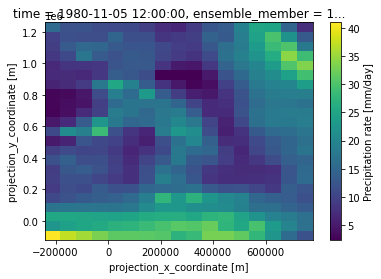

In [326]:
gcmdata.sel({'ensemble_member': 1}).isel({'time': 334}).pr.plot()